**Deep Learning**

**Practice 3.1 - GANs**

**Marcelo Ferrer - Aymen Merchaoui**


## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [36]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

Using GPU


In [37]:
import numpy as np
import glob, os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
import matplotlib.pyplot as plt
from matplotlib import pyplot


In [38]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Load the images

In [41]:
DATA_FOLDER = "dataset/img_align_celeba/"
WEIGHTS_FOLDER = 'dataset/weights/'

if not os.path.exists(WEIGHTS_FOLDER):
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))


filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599

Total number of images : 202599


In [81]:
INPUT_DIM = (16,16,3) # Image dimension
BATCH_SIZE = 64
Z_DIM = 100 # Dimension of the latent vector (z)


data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training'
    )

Found 202599 images belonging to 1 classes.


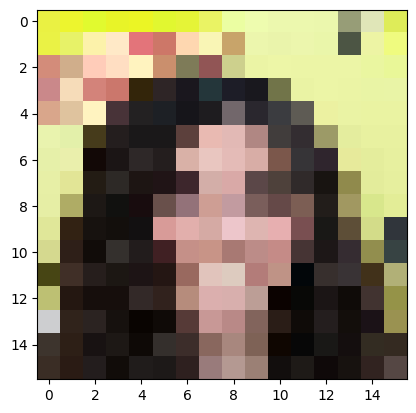

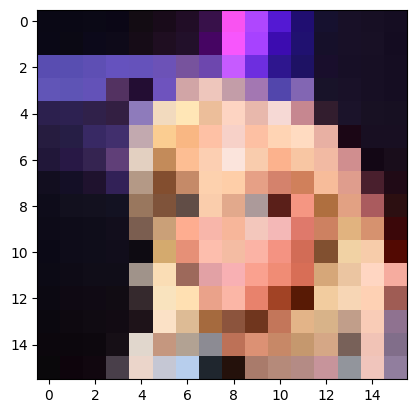

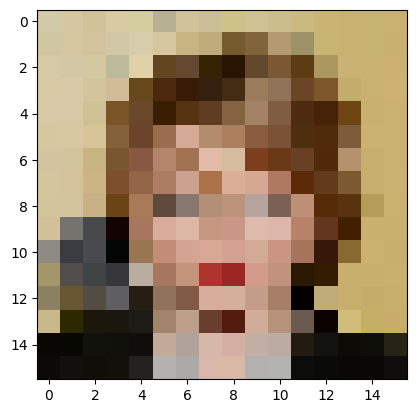

In [82]:
batch = data_flow.next()
for i in range(0,3):
    image = batch[0][i]
    plt.imshow(image)
    plt.show()

In [83]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
    
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)

    # Define model output
    encoder_output = Dense(output_dim, name = 'encoder_output')(x)

    return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = [32, 64, 64, 64],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 16, 16, 3)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 8, 8, 32)          896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 32)          0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 4, 4, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 2, 2, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2, 2, 64)          0     

In [84]:
# -----------------------------------------------
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = shape_before_flattening,
    conv_filters = [64,64,32,3],        
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 reshape (Reshape)           (None, 1, 1, 64)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 2, 2, 64)         36928     
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2, 2, 64)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 4, 4, 64)         36928     
 pose)                                                     

In [85]:

simple_autoencoder_input = encoder_input

simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 16, 16, 3)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 8, 8, 32)          896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 32)          0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 4, 4, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 64)          0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 2, 2, 64)          36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2, 2, 64)          0   

In [86]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=adam_optimizer, loss = r_loss)

simple_autoencoder.fit(data_flow, 
    shuffle=True, 
    epochs = N_EPOCHS, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

simple_autoencoder.save(os.path.join(WEIGHTS_FOLDER, 'AE/model.h5'))


Epoch 1/10
  51/3165 [..............................] - ETA: 17:39 - loss: 0.0904

KeyboardInterrupt: 